Instalar las siguientes librerias y reiniciar el kernel

In [ ]:
!pip install tensorflow
!pip install keras
!pip install --upgrade keras
!pip install ipympl

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from time import time
import logging
import os

# Estas dos lineas son para silenciar las advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
import keras

from tf_regressor import train_test_split_scale_center

# Redes Neuronales

### Laboratorio de Datos, IC - FCEN - UBA - 1er. Cuatrimestre 2024

### 1. Perceptrón Simple : clasificación binaria 

Armaremos una red neuronal para predecir si una persona tiene o no diabetes a partir de 8 caracteristicas:
- Embarazos
- Glucosa
- Presión sanguínea
- Grosor de la piel
- Insulina
- Indice de masa corporal (BMI)
- Antecedentes familiares
- Edad

Como se trata de un problema de clasificación, la función de activación será la función sigmoidea.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# Cargamos el dataset y descartamos las observaciones con campos faltantes
data = pd.read_csv("../_src/Datasets/diabetes.csv")
data.dropna(inplace=True)

# Definimos las variables.
X = data.drop('Outcome', axis=1)    # Queremos todas las columnas salvo Outcome
y = data['Outcome']

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, test_size=0.2, random_state=42)

In [15]:
# En pro de la reproducibilidad, especificamos la semilla para keras
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(8,)),             # Capa de input: indicamos que el input tiene dimension 8
    keras.layers.Dense(1,                       # Capa de output: el output tiene dimension 1 (clasificacion binaria)
                       activation='sigmoid')    # y su funcion de activacion es la sigmoidea.
])

In [32]:
# Paso 2: configuramos el optimizador: usaremos Descenso por Gradiente Estocástico con learning rate constante 0.5
# Documentacion SGD : https://keras.io/api/optimizers/sgd/ 
optimizer = keras.optimizers.SGD(learning_rate=0.5)

In [33]:
# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,            # Optimizador a utilizar
    loss='binary_crossentropy',     # Funcion de perdida para clasificacion binaria (log loss para los amigos)
    metrics=['accuracy',            # Metricas a registrar durante el entrenamiento
             'false_negatives']            
)

In [34]:
# Paso 4: entrenamiento del modelo. 
# model.fit devuelve un objeto History que guarda la evolucion del valor de la funcion de perdida y de las metricas 
# luego de cada epoca.
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    # Ingresamos los datos de entrenamiento
                 epochs=150,                                 # Especificamos la cantidad de épocas
                 batch_size=20,                             # Especificamos el tamaño del batch
                 validation_split=0.2,                      # 20% de datos para validación
                 verbose=0,                                 # Opcional, para que no muestre el proceso de entrenamiento.
                 )

In [35]:
# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'accuracy': 0.7597402334213257,
 'false_negatives': 20.0,
 'loss': 0.5326725244522095}

In [12]:
# Armamos una funcion para graficar el error a través de las épocas
def graficar_error(history, error_name):
    x_arr = np.array(history.epoch)    # en el atributo epoch, history guarda una lista de epocas
    plot = (
        so.Plot()
        .add(so.Line(color='blue'), x=x_arr, y=history.history[error_name], label='Entrenamiento')
        .add(so.Line(color='orange'), x=x_arr, y=history.history[f'val_{error_name}'], label='Validacion')
        .label(title=error_name)
    )
    plot.show()

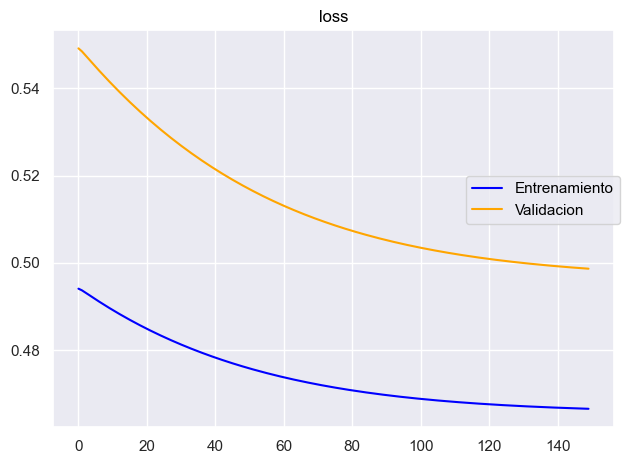

In [40]:
graficar_error(hist, 'loss')

Analizando los pesos, podemos interpretar qué factor es más influyente en el diagnóstico de diabetes

In [37]:
# Aqui se guardan los pesos en la primera coordenada y el bias en la segunda
model.weights

# Recuperamos los pesos:
weights = model.weights[0].numpy().flatten()

# Armamos una Serie para simplificar el análisis
pd.Series(weights, index=X_train.columns, name='Peso en la RN')

Pregnancies      0.702831
Glucose          7.731458
BloodPressure   -1.711889
SkinThickness    0.436010
Insulin         -2.913708
BMI              7.636390
Pedigree         1.758973
Age              2.463747
Name: Peso en la RN, dtype: float32

### 2. Perceptrón Simple : clasificación en más de dos categorías

Ahora, dadas las cuatro características de los pingüinos (peso, longitud de aleta y profundidad y longitud del pico), 
intentaremos predecir de qué especie es (Adelie, Chinstrap o Gentoo).

In [38]:
# Cargamos el dataset y descartamos las observaciones con campos faltantes
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Como en el dataset los pinguinos estan ordenados por especie, estaria bueno mezclar el DataFrame
penguins = penguins.sample(len(penguins))

# Definimos las variables.
X = penguins[['bill_length_mm', 'flipper_length_mm', 'bill_depth_mm', 'body_mass_g']]
# Armamos una Serie las etiquetas: 0 corresponde a Gentoo, 1 corresponde a Adelie, 2 corresponde a Chinstrap
y = penguins['species'].apply(lambda x: 1*(x == 'Adelie') + 2*(x == 'Chinstrap'))    

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, test_size=0.2, random_state=21)

In [41]:
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(4,)),             # Capa de input: indicamos que el input tiene dimension 4
    keras.layers.Dense(3,                       # Capa de output: el output tiene dimension 3 (una neurona para cada especie)
                       activation='sigmoid')    # y su funcion de activacion es la sigmoidea.
])

# Paso 2: configuramos el optimizador
optimizer = keras.optimizers.SGD(learning_rate=0.5)

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,                        
    loss='sparse_categorical_crossentropy',     # Funcion de perdida para clasificacion con mas de dos categorias
    metrics=['accuracy']                        
)

# Paso 4: entrenamiento del modelo. 
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    
                 epochs=150,                                 
                 batch_size=20,                             
                 validation_split=0.2,                      
                 verbose=0,                                 
                 )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'accuracy': 0.9552238583564758, 'loss': 0.09110856801271439}

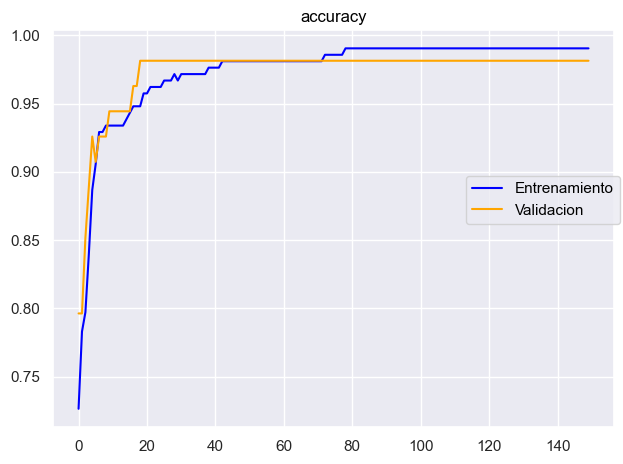

In [42]:
# Graficamos la evolucion de la precision de la clasficiacion
graficar_error(hist, 'accuracy')

### 3. Perceptrón Multicapa

In [39]:
data = pd.read_csv('../_src/Datasets/nutrition.csv')
data.isna().sum()

FDC_ID                0
Item                  0
Category              0
Calorias_kcal         0
Proteinas_g           0
Carbohidratos_g       0
GrasaTotal_g          0
Colesterol_mg       399
Fibra_g             562
Agua_g                0
Alcohol_g          2394
VitaminaC_mg        461
dtype: int64

In [43]:
data.shape

(7793, 12)

In [44]:
data.dropna(inplace=True)
data.columns

Index(['FDC_ID', 'Item', 'Category', 'Calorias_kcal', 'Proteinas_g',
       'Carbohidratos_g', 'GrasaTotal_g', 'Colesterol_mg', 'Fibra_g', 'Agua_g',
       'Alcohol_g', 'VitaminaC_mg'],
      dtype='object')

In [45]:
X = data.drop(columns=['FDC_ID', 'Item', 'Category', 'Calorias_kcal'])
y = data['Calorias_kcal']

# Escalamos y centramos X, definimos conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, transform_y=True, test_size=0.2, random_state=21)

In [46]:
keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)), 
    keras.layers.Dense(4,                       
                       activation='sigmoid'),
    keras.layers.Dense(1,                       
                       activation='sigmoid')    
])

# Paso 2: configuramos el optimizador
optimizer = keras.optimizers.SGD(learning_rate=0.5)

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,                        
    loss='mean_squared_error',                    
)

# Paso 4: entrenamiento del modelo. 
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),    
                 epochs=100,                                 
                 batch_size=20,                             
                 validation_split=0.2,                      
                 verbose=0,                                 
                 )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               verbose=0,
               batch_size=len(y_test),
               return_dict=True
               )

{'loss': 0.0011638907017186284}

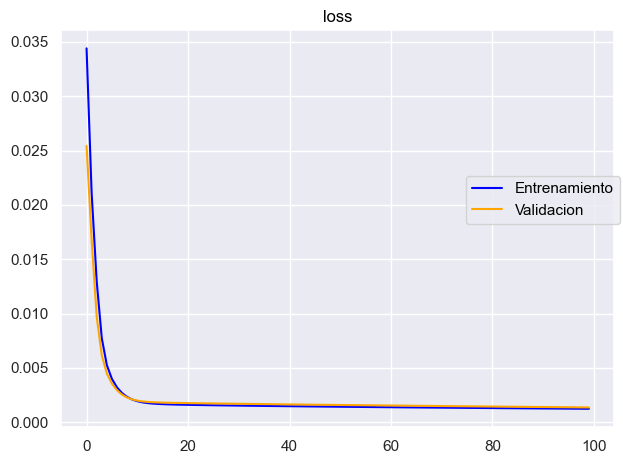

In [50]:
graficar_error(hist, 'loss')

In [48]:
graficar_error(hist, '')

KeyError: 'accuracy'